## TensorFlow Today: Declarative (Graphs)

## Graphs are ..

### Optimizable
- automatic buffer reuse
- constant folding
- inter-op parallelism
- automatic trade-off between compute and memory

### Deployable
- the Graph is an intermediate representation for models

### Rewritable
- experiment with automatic device placement or quantization


## But graphs are also ...

### Difficult to debug
- errors are reported long after graph construction
- execution cannot be debugged with pdb or print statements

### Un-Pythonic
- writing a TensorFlow program is an exercise in metaprogramming
- control flow (e.g., tf.while_loop) differs from Python
- can't easily mix graph construction with custom data structures

## Eager Execution

"A NumPy-like library for numerical computation with support for GPU acceleration and automatic differentiation, and a flexible platform for machine learning research and experimentation." 

 - the eager execution user guide(https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/g3doc/guide.md)

## EE Live Demo

In [2]:
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
print(os.getcwd())


/Users/surkpark/cs20si_study


In [3]:
import sys
sys.path.append(os.getcwd()+"/examples")

In [4]:
import utils

DATA_FILE = "./examples/data/birth_life_2010.txt"

In [5]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import matplotlib.pyplot as plt

In [6]:
# In order to use eager execution, `tfe.enable_eager_execution()` must be
# called at the very beginning of a TensorFlow program.
tfe.enable_eager_execution()

In [7]:
# Read the data into a dataset.
data, n_samples = utils.read_birth_life_data(DATA_FILE)
dataset = tf.data.Dataset.from_tensor_slices((data[:,0], data[:,1]))

In [8]:
# Create weight and bias variables, initialized to 0.0.
w = tfe.Variable(0.0)
b = tfe.Variable(0.0)

In [9]:
# Define the linear predictor.
def prediction(x):
  return x * w + b

In [10]:
# Define loss functions of the form: L(y, y_predicted)
def squared_loss(y, y_predicted):
  return (y - y_predicted) ** 2

In [11]:
def huber_loss(y, y_predicted, m=1.0):
  """Huber loss."""
  t = y - y_predicted
  # Note that enabling eager execution lets you use Python control flow and
  # specificy dynamic TensorFlow computations. Contrast this implementation
  # to the graph-construction one found in `utils`, which uses `tf.cond`.
  return t ** 2 if tf.abs(t) <= m else m * (2 * tf.abs(t) - m)

In [12]:
def train(loss_fn):
  """Train a regression model evaluated using `loss_fn`."""
  print('Training; loss function: ' + loss_fn.__name__)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

  # Define the function through which to differentiate.
  def loss_for_example(x, y):
    return loss_fn(y, prediction(x))

  # `grad_fn(x_i, y_i)` returns (1) the value of `loss_for_example`
  # evaluated at `x_i`, `y_i` and (2) the gradients of any variables used in
  # calculating it.
  grad_fn = tfe.implicit_value_and_gradients(loss_for_example)

  start = time.time()
  for epoch in range(100):
    total_loss = 0.0
    for x_i, y_i in tfe.Iterator(dataset):
      loss, gradients = grad_fn(x_i, y_i)
      # Take an optimization step and update variables.
      optimizer.apply_gradients(gradients)
      total_loss += loss
    if epoch % 10 == 0:
      print('Epoch {0}: {1}'.format(epoch, total_loss / n_samples))
  print('Took: %f seconds' % (time.time() - start))
  print('Eager execution exhibits significant overhead per operation. '
        'As you increase your batch size, the impact of the overhead will '
        'become less noticeable. Eager execution is under active development: '
        'expect performance to increase substantially in the near future!')

In [13]:
train(huber_loss)

Training; loss function: huber_loss
Epoch 0: 106.16918182373047
Epoch 10: 53.64773178100586
Epoch 20: 42.586669921875
Epoch 30: 31.845298767089844
Epoch 40: 21.576385498046875
Epoch 50: 12.379732131958008
Epoch 60: 8.386137962341309
Epoch 70: 7.563107013702393
Epoch 80: 7.398852348327637
Epoch 90: 7.382768630981445
Took: 56.972176 seconds
Eager execution exhibits significant overhead per operation. As you increase your batch size, the impact of the overhead will become less noticeable. Eager execution is under active development: expect performance to increase substantially in the near future!


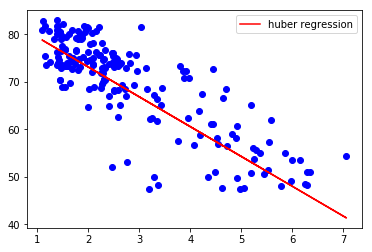

In [14]:
plt.plot(data[:,0], data[:,1], 'bo')
# The `.numpy()` method of a tensor retrieves the NumPy array backing it.
# In future versions of eager, you won't need to call `.numpy()` and will
# instead be able to, in most cases, pass Tensors wherever NumPy arrays are
# expected.
plt.plot(data[:,0], data[:,0] * w.numpy() + b.numpy(), 'r',
         label="huber regression")
plt.legend()
plt.show()

## EE Key Advantages

- Compatible with Python debugging tools
    * pdb.set_trace() to your heart's content!
- Provides immediate error reporting
- Permits use of Python data structures
    * e.g., for structured input
- Enables easy, Pythonic control flow
    * if statements, for loops, recursion, oh my!  
    
    <pre><code>
    i = tf.constant(0)
    while i < 1000:
        i = tf.add(i, 1)
        print("I could this all day!!! %d" % i)
    </code></pre>

## Eager execution simplifies your code

## You no longer need to worry about ...

1. placeholders
2. sessions
3. control dependencies
4. "lazy loading"
5. {name, variable, op} scopes


## TF Boilerplate not using EE

In [15]:
x = tf.placeholder(tf.float32, shape=[1, 1])
m = tf.matmul(x, x)

print(m)
# Tensor("MatMul:0", shape=(1, 1), dtype=float32)

with tf.Session() as sess:
  m_out = sess.run(m, feed_dict={x: [[2.]]})
print(m_out)
# [[4.]]

RuntimeError: tf.placeholder() is not compatible with eager execution.

## TF Boilerplate using EE

In [16]:
x = [[2.]]  # No need for placeholders!
m = tf.matmul(x, x)

print(m)  # No sessions!
# tf.Tensor([[4.]], shape=(1, 1), dtype=float32)


tf.Tensor([[4.]], shape=(1, 1), dtype=float32)


## Lazy Roading

In [ ]:
x = tf.random_uniform([2, 2])

with tf.Session() as sess:
  for i in range(x.shape[0]):
    for j in range(x.shape[1]):
      print(sess.run(x[i, j])) # Each iteration adds nodes to the graph


## Lazy Roading does not happen with EE

In [17]:
x = tf.random_uniform([2, 2])

for i in range(x.shape[0]):
  for j in range(x.shape[1]):
    print(x[i, j])

tf.Tensor(0.09114444, shape=(), dtype=float32)
tf.Tensor(0.14308941, shape=(), dtype=float32)
tf.Tensor(0.08035076, shape=(), dtype=float32)
tf.Tensor(0.070757866, shape=(), dtype=float32)


## Tensors Act Like NumPy Arrays

In [19]:
import numpy as np

x = tf.constant([1.0, 2.0, 3.0])


# Tensors are backed by NumPy arrays
assert type(x.numpy()) == np.ndarray ## Caveat: use tf.equal to compare Tensors, not ==
squared = np.square(x) # Tensors are compatible with NumPy functions
 
# Tensors are iterable!
for i in x:
  print(i)

tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(3.0, shape=(), dtype=float32)


## Gradients

### Automatic differentiation is built into eager execution

### Under the hood ...

- Operations are recorded on a tape
- The tape is played back to compute gradients
    * This is reverse-mode differentiation (backpropagation).


In [21]:
def square(x):
  return x ** 2

grad = tfe.gradients_function(square) # Differentiate w.r.t. input of square

print(square(3.))    # tf.Tensor(9., shape=(), dtype=float32)


9.0


In [22]:
print(grad(3.))      # [tf.Tensor(6., shape=(), dtype=float32))]

[<tf.Tensor: id=836335, shape=(), dtype=float32, numpy=6.0>]


In [23]:
x = tfe.Variable(2.0) # Use tfe.Variable when eager execution is enabled
def loss(y):
  return (y - x ** 2) ** 2

grad = tfe.implicit_gradients(loss) # Differentiate w.r.t. variables used to compute loss

print(loss(7.))  # tf.Tensor(9., shape=(), dtype=float32)

tf.Tensor(9.0, shape=(), dtype=float32)


In [25]:
print(grad(7.))  # [(<tf.Tensor: -24.0, shape=(), dtype=float32>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>)]

[(<tf.Tensor: id=836400, shape=(), dtype=float32, numpy=-24.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>)]


## Gradient APIs for computing gradients work even when eager execution is not enabled

#### tfe.gradients_function()
#### tfe.value_and_gradients_function()
#### tfe.implicit_gradients()
#### tfe.implicit_value_and_gradients()


## A Collection of Operations

### TensorFlow = Operation Kernels + Execution

- Graph construction: Execute compositions of operations with Sessions
- Eager execution: Execute compositions with Python 

### Majority of TF API works regardless of whether eager execution is enabled.

- But, when eager execution is enabled  …
    * prefer tfe.Variable under eager execution (compatible with graph construction)
    * manage your own variable storage — variable collections are not supported!
    * use tf.contrib.summary
    * use tfe.Iterator to iterate over datasets under eager execution
    * prefer object-oriented layers (e.g., tf.layers.Dense) 
    * functional layers (e.g., tf.layers.dense) only work if wrapped in tfe.make_template
    * prefer tfe.py_func over tf.py_func

- See the user guide for details and updates (https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/g3doc/guide.md)

## What if I like graphs?

### Imperative to declarative and back

- Write model definition code once
    * The same code can execute operations in one Python process and construct graphs in another (see user guide/examples) ((https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/g3doc/guide.md))

- Checkpoints are compatible
    * Train eagerly, checkpoint, load in a graph, or vice-versa

- Create graphs while eager execution is enabled:
    * tfe.defun: "Compile" computation into graphs and execute them.

## So when should I use eager execution?

### Use eager if you're ...

- a researcher and want a flexible framework
    * python control flow and data structures enable experimentation
- developing a new model
    * immediate error reporting simplifies debugging
- new to TensorFlow
    * eager execution lets you explore the TF API in the Python REPL


## EE Status

- Available in version 1.5 of TensorFlow (import tf.contrib.eager as tfe)
- Single GPU, ResNet benchmark performance comparable to graphs
- Under active development
    * Overheads on smaller operations are significant
    * Distributed support is in the works
    * Not all TF APIs are eager-compatible


## Further reading

### Read the user guide to learn about …

- High-level, Keras-like APIs for constructing models
    * tfe.Network, tf.layers.Layer
- Checkpointing variables
- Summaries and tensorboard
- Custom gradients for numerical stability
- Using GPUs

### Check out the examples folder for idiomatic code
(https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/eager/python/examples)